In [ ]:
import re
def parse(row):
    numbers = re.findall(r'\d+', row[0])
    numbers = list(map(int, numbers))
    value = int(row[1])
    return (numbers, value)
    

In [ ]:
# Sigmoid function
def sigmoid(z):
    result = 1.0 / (1.0 + np.e**-z)
    return result

In [74]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [82]:
import csv
import numpy as np
import scipy as sp
firstrow = True
X = np.zeros((1000,10000)) #movies, users
with open('data_train.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if not firstrow:
            numbers, value = parse(row) #numbers is (columns, rows)
            X[numbers[1]-1, numbers[0]-1] = value 
        else:
            firstrow = False

In [75]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#do simple SVD

U, D, V = svds(X, k=40)
X_a = np.dot(np.dot(U, np.diag(D)), V)

print ('SVD MSE: ' + str(rmse(X_a, X)) + " STD: " + str(np.std(X_a - X)))

SVD MSE: 1.1574378043774212 STD: 1.15743575388


In [121]:
averageRatingPerMovie = X.sum(1)/(X != 0).sum(1) #(1000,1)

#simple Prediction, no need to train anything...

def predictRating_Baseline(movie,user):
    averageRating = averageRatingPerMovie[movie]
    ratingsByUser_indices = X[:,user] > 0
    averageOffset = np.mean(averageRatingPerMovie[ratingsByUser_indices] - X[ratingsByUser_indices, user])
    return averageRating + averageOffset

In [184]:
#use this for Netflix
def predictRating(movie, user):
    #maybe do some feature transformation sigmoid
    predict = np.dot(movieFeature[:, movie],userFeature [:, user])
    if predict > 5:
        predict = 5
    else:
        if predict < 1:
            predict = 1
    return predict

In [205]:
#for Netflix

#params
lrate = 0.001

#simpler approach
def train(movie, user, feature, firstRound):
    true_rating = X[movie, user]
    if firstRound: 
        predicted_rating = predictRating_Baseline(movie,user)
        err = (true_rating - predicted_rating)
        #print("Predicted: "+ str(predicted_rating) + " True: " + str(true_rating))
    else:
        predicted_rating = predictRating(movie,user)
        err = (true_rating - predicted_rating)
        #print("Predicted: "+ str(predicted_rating) + " True: " + str(true_rating))
    uv = userFeature[feature, user]
    userFeature[feature, user] = uv + lrate * err * movieFeature[feature, movie]
    movieFeature[feature, movie] = lrate * movieFeature[feature, movie] + err * uv
    return err

In [199]:
#for Netflix

#params
lrate = 0.001
K = 0.02

#works well if k is large
def train_tikhonov(movie, user, feature, firstRound):
    true_rating = X[movie, user]
    if firstRound: 
        predicted_rating = predictRating_Baseline(movie,user)
        err = (true_rating - predicted_rating)
        #print("Predicted: "+ str(predicted_rating) + " True: " + str(true_rating))
    else:
        predicted_rating = predictRating(movie,user)
        err = (true_rating - predicted_rating)
        #print("Predicted: "+ str(predicted_rating) + " True: " + str(true_rating))
    uv = userFeature[feature, user]
    userFeature[feature, user] = uv + lrate * (err * movieFeature[feature, movie] - K * uv)
    movieFeature[feature, movie] = movieFeature[feature, movie] + lrate * (err * uv - K * movieFeature[feature, movie])
    return err

In [ ]:
#NETFLIX

#parameters
k = 200
n_epochs = 10
#for k=40 takes approx 3min per epoch
#for k=100 takes approx 11min per epoch

#remove/comment out the following two lines if you want to train your model even further
movieFeature = np.zeros((k,1000)) + 0.1
userFeature = np.zeros((k,10000)) + 0.1

for epoch in range(n_epochs):
    for feature in range(k):
        errors = []
        movie_indices, user_indices = np.nonzero(X)
        for i in range(len(movie_indices)):
            movie = movie_indices[i]
            user = user_indices[i]
            #change to tikhonov, is converging quicker (also used for Netflix competition)
            error_squared = train_tikhonov(movie, user, feature, epoch==-1) ** 2
            errors.append(error_squared)
        print("Errors of feature " + str(feature) + ": rmse " + str(np.sqrt(np.mean(errors))))

print(movieFeature)
print(userFeature)

Errors of feature 0: rmse 2.12189344823
Errors of feature 1: rmse 2.01236409378
Errors of feature 2: rmse 1.92539227428
Errors of feature 3: rmse 1.85346893571
Errors of feature 4: rmse 1.792374582
Errors of feature 5: rmse 1.73947858653
Errors of feature 6: rmse 1.69302009491
Errors of feature 7: rmse 1.65175745518


In [198]:
#Output file

#make sure to have X_a or have
#movieFeature and userFeature trained

import csv
import numpy as np
import time
firstrow = True
requested_y = []
with open('sampleSubmission.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if not firstrow:
            numbers, value = parse(row)
            requested_y.append(numbers)
        else:
            firstrow = False
            
        
with open('submission-'+(time.strftime('%Y-%m-%d-%a-%Hh%Mmin'))+'.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['ID','Prediction'])
    for coord in requested_y:
        r = coord[0]
        c = coord[1]
        #value = int(X_a[c-1, r-1]) #exchange this if desired
        value = predictRating(c-1, r-1)
        writer.writerow(['r%d_c%d'%(r, c) , str(value)])


/Users/Andres/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Andres/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


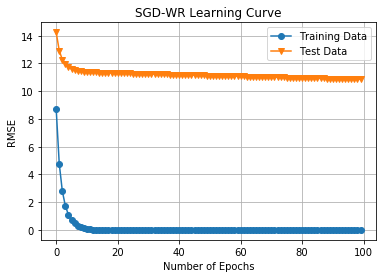

,Actual Rating,Predicted Rating


In [66]:
#from http://online.cambridgecoding.com/notebooks/mhaller/implementing-your-own-recommender-systems-in-python-using-stochastic-gradient-descent-4

import numpy as np
import pandas as pd
from sklearn import cross_validation as cv
import matplotlib.pyplot as plt
%matplotlib inline

n_users = 1000
n_items = 10000

df = X.T

train_data, test_data = cv.train_test_split(df,test_size=0.25)
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Create training and test matrix
R = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]  

T = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]
    
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

# Predict the unknown ratings through the dot product of the latent features for users and items 
def prediction(P,Q):
    return np.dot(P.T,Q)

lmbda = 0.1 # Regularisation weight
k = 10  # Dimension of the latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 100  # Number of epochs
gamma=0.01  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

train_errors = []
test_errors = []

#Only consider non-zero matrix 
users,items = R.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
    train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
# Check performance by plotting train and test errors

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

# Calculate prediction matrix R_hat (low-rank approximation for R)
R = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.015337,0.007299,0.010588,0.011165,0.011180,0.014249,0.011248,0.015370,0.013733,0.012961,...,0.010781,0.013766,0.013827,0.014494,0.013760,0.011301,0.010944,0.012699,0.012335,0.014055
1,0.011155,0.008873,0.008752,0.010784,0.008891,0.012788,0.009840,0.011300,0.009499,0.011687,...,0.009966,0.010472,0.011846,0.010921,0.012054,0.009988,0.012165,0.009636,0.011753,0.012309
2,0.011067,0.006224,0.008608,0.012278,0.011548,0.014904,0.010863,0.010753,0.011168,0.011200,...,0.012003,0.014975,0.010408,0.008471,0.013048,0.012160,0.010368,0.006762,0.009971,0.011726
3,0.008046,0.000995,0.005805,0.005528,0.006003,0.008535,0.006895,0.008894,0.008034,0.006698,...,0.004598,0.008670,0.007534,0.007797,0.006399,0.006071,0.005387,0.006953,0.005471,0.006049
4,0.007177,0.005826,0.002481,0.006553,0.007028,0.004060,0.005168,0.006508,0.006463,0.004443,...,0.005368,0.006170,0.006398,0.006593,0.004529,0.003715,0.005033,0.003886,0.003729,0.006692
5,0.012889,0.005289,0.010624,0.009463,0.010185,0.013370,0.011477,0.013972,0.011654,0.009657,...,0.010951,0.013677,0.012720,0.011260,0.012219,0.011459,0.010148,0.010414,0.011556,0.012153
6,0.014023,0.012147,0.007731,0.014840,0.012249,0.010949,0.009139,0.012346,0.012442,0.010510,...,0.014777,0.013528,0.009493,0.011746,0.012998,0.009158,0.009227,0.007209,0.010870,0.016286
7,0.011778,0.007351,0.007214,0.013343,0.010821,0.012427,0.009734,0.012024,0.012361,0.011096,...,0.009606,0.013086,0.010644,0.012163,0.010471,0.007632,0.010325,0.009030,0.008034,0.013088
8,0.007732,0.005110,0.006124,0.009130,0.005762,0.009085,0.007488,0.008692,0.007056,0.006992,...,0.007311,0.008043,0.007117,0.007960,0.006553,0.005921,0.008205,0.005912,0.008116,0.008988
9,0.009994,0.005612,0.007151,0.009247,0.009169,0.010557,0.008554,0.009574,0.009865,0.009016,...,0.008660,0.010583,0.010990,0.010837,0.010680,0.009052,0.008942,0.008000,0.008493,0.011395


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
